### Data Load

In [1]:
dir_data = 'data/'
dir_raw = 'data/raw/'
dir_preprocessed = 'data/preprocessed/'

##### Librerias

En este apartado, vamos a importar todas las librerías necesarias para realizar las tareas de la práctica, como el análisis y procesamiento de datos, generar el modelo, etc. Estas librerías son numpy, matplotlib, pandas, seaborn, xgboost, sklearn y shap. Estas librerías nos permiten manipular, visualizar y analizar los datos de manera eficiente.

In [2]:
# Librerias
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### EDA

Una vez que se han cargado, se pueden configurar algunas opciones para optimizar la visualización y el manejo de datos en pandas:

In [3]:
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', None)     # Muestra todas las filas (¡cuidado con dataframes muy grandes!)
pd.set_option('display.width', 1000)        # Ajusta el ancho del output
pd.set_option('display.expand_frame_repr', False)  # Evita saltos de linea en columnas grandes


##### Análisis preliminar

Transformamos todos los archivos en formato CSV y añadimos una fila al final indicando la maniobra que se está representando en el conjunto de datos.

In [4]:
# Asignar otro atributo a cada dataframe de cada archivo (el nombre del archivo) y eliminacion de la primera parte 'STISIMData:'.

files = os.listdir(dir_raw)
dfs = []
for driver in files:
    files = os.listdir(dir_raw + driver)
    for file in files:
        df = pd.read_excel(dir_raw + driver + '/' + file)
        df['maniobra'] = file[11:-5]
        df.to_csv(dir_preprocessed + '/column_added/' + driver + '_' + file[11:-5], index=False)
        dfs.append(df)
        #print(file + ' processed')
    print(driver + ' processed')

Driver1 processed
Driver2 processed
Driver3 processed
Driver4 processed
Driver5 processed


In [5]:
dfs = []
for file in os.listdir(dir_preprocessed + '/column_added'):
    df = pd.read_csv(dir_preprocessed + '/column_added/' + file)
    dfs.append(df)

##### Count Values

In [6]:
for df in dfs:
    print(df.shape)

(8933, 24)
(5952, 24)
(11589, 24)
(5308, 24)
(5801, 24)
(9191, 24)
(6263, 24)
(11515, 24)
(6315, 24)
(5206, 24)
(8965, 24)
(7137, 24)
(12561, 24)
(15139, 24)
(7087, 24)
(11976, 24)
(6022, 24)
(12070, 24)
(7658, 24)
(6437, 24)
(8662, 24)
(6183, 24)
(11551, 24)
(11281, 24)
(5984, 24)


##### Valores Faltantes

Es importante verificar si hay valores faltantes en los datos, ya que pueden afectar el rendimiento del modelo. Para ello, calculamos la media de los valores faltantes por columna en cada DataFrame y mostramos los resultados.

In [7]:
# plot missing values
for df in dfs:
    print(df.isnull().mean())
    # Heatmap para visualizar los valores faltantes
    # sns.heatmap(df.isnull(), cbar=False)
    # plt.show()

Elapsed time            0.000000
Long Dist               0.000000
Lat Pos                 0.000000
Steering wheel angle    0.000000
Throttle input          0.000000
Brake pedal force       0.000000
Gas pedal               0.000000
Brake pedal             0.000000
Clutch pedal            0.000000
Left turn               0.000000
Right turn              0.000000
Gear                    0.000000
speed                   0.000000
RPM                     0.000000
Hand wheel torque       0.000000
Maneuver marker flag    0.000000
Accidents               0.999888
Collisions              0.999888
Peds Hit                0.999888
Speeding Tics           0.999888
Red Lgt Tics            0.999888
Speed Exceed            0.999888
Stop Sign Ticks         0.999888
maniobra                0.000000
dtype: float64
Elapsed time            0.000000
Long Dist               0.000000
Lat Pos                 0.000000
Steering wheel angle    0.000000
Throttle input          0.000000
Brake pedal force       0.00

Como podemos ver, hay columnas que tienen una gran cantidad de valores faltantes (>99%), por lo que procedemos a eliminarlas.

Aunque pueden ser relevantes, las consideramos no informativas ya que la cantidad es demasiado pequeña y representan casos extraordinarios.

In [8]:
dfs = [df.drop( columns=['Accidents', 'Collisions', 'Peds Hit', 'Speeding Tics', 'Red Lgt Tics', 'Speed Exceed', 'Stop Sign Ticks']) for df in dfs]

Utilizaremos principalmente los atributos que se aconseja en el enunciado:

* Speed - Velocidad
* RPM - Revoluciones por minuto 
* Steering Wheel angle - Ángulo del volante.  
* Gas Pedal - Pedal del acelerador. 
* Brake Pedal - Pedal del freno (b),  
* Clutch Pedal - Pedal del embrague  
* Gear – Marcha.

Nota: Tras ejecutar el modelo (clasificación multiclase con xgboost) con un extremadamente alto rendimiento, se sospechó de que hubiese fuga de datos. Para comprobarlo, se realizaron varias pruebas iterativas quitando atributos de manera selectiva hasta que se vio una caída abismal de la precisión cuando se quitaron los atributos de Latitud y Longitud. Se sospecha que esto podría ser algo del simulador de donde se obtuvieron los datos (más explicación al final).

In [9]:
dfs = [df.drop(columns=['Elapsed time', 'Long Dist', 'Lat Pos', 'Hand wheel torque', 'Throttle input']) for df in dfs]

In [10]:
dfs[0].head()

,Steering wheel angle,Brake pedal force,Gas pedal,Brake pedal,Clutch pedal,Left turn,Right turn,Gear,speed,RPM,Maneuver marker flag,maniobra
0,-8.24,1.36,0,0,0,0,0,0,0.06,147.244,0,3step-Turnings
1,-8.24,1.36,0,0,0,0,0,0,0.04,184.118,0,3step-Turnings
2,-8.24,1.36,0,0,0,0,0,0,0.02,219.193,0,3step-Turnings
3,-8.24,1.36,0,0,0,0,0,0,0.00,252.554,0,3step-Turnings
4,-8.24,1.36,0,0,0,0,0,0,0.00,284.287,0,3step-Turnings


Una vez que los datos están cargados y preprocesados, obtenemos una visión general de las estadísticas descriptivas de las columnas. Esto nos ayuda a entender las distribuciones y el rango de los datos, así como a identificar posibles valores atípicos.

In [11]:
for df in dfs:
    # Imprimir el maximo, minimo y promedio de cada columna
    print(df.describe().loc[['max', 'min', 'mean']])

      Steering wheel angle  Brake pedal force     Gas pedal   Brake pedal  Clutch pedal  Left turn  Right turn      Gear      speed          RPM  Maneuver marker flag
max             414.060000          87.160000  59627.000000  29041.000000  64253.000000   1.000000         0.0  4.000000  84.590000  4774.648000              1.000000
min            -466.580000           1.360000      0.000000      0.000000      0.000000   0.000000         0.0 -1.000000   0.000000   124.919000              0.000000
mean             -4.288223           4.866916  19731.515392   1187.196239  32681.562745   0.115527         0.0  0.983656  27.076534  1690.436524              0.591627
      Steering wheel angle  Brake pedal force     Gas pedal   Brake pedal  Clutch pedal  Left turn  Right turn      Gear      speed          RPM  Maneuver marker flag
max              22.660000          30.970000  53331.000000  10023.000000  64253.000000    1.00000    1.000000  4.000000  90.610000  4119.349000              1.00000

Procedemos a ver como se distribuyen los valores de cada atributo de cada tipo de maniobra.

Se observa que los datos están en un rango determinado y se observan los siguientes tipos de distribuciones:
* Normal o Gausiana: ángulo del volante.
* Distribuciones Normal pero sesgado: Velocidades o RPM
* Binario: Direcciones de giro.
* Valores discretos en un rango: Gears

In [12]:
# for df in dfs:
#     df.hist(figsize=(20, 20))
#     plt.suptitle(df['maniobra'][0])
#     plt.show()

No vemos valores atípicos claros o valores incorrectos, siendo todos en un rango definido, por lo que no eliminaremos ninguna instancia.

Dado que sigue habiendo datos recogido por los sensores despues de la última maniobra realizada, procederemos a eliminar estos datos recopilados ya que no los podremos usar para predecir futuras maniobras.

In [13]:
print(dfs.__len__())

25


In [14]:
dfs_cleaned = []
for df in dfs:
    # Encuentra los indices donde 'Maneuver marker flag' es 1
    marker_indices = df[df['Maneuver marker flag'] == 1].index

    if not marker_indices.empty:  # Si hay al menos una maniobra en la columna
        last_index = marker_indices[-1]  # Ultima ocurrencia de maniobra
        dfs_cleaned.append(df.iloc[:last_index + 1])  # Mantener todo hasta ahi

    # si no hay maniobras en el df, entonces no nos hace falta el df

dfs = dfs_cleaned

verificamos que en efecto, no hay datasets sin maniobra

In [15]:
print(dfs.__len__())

25


Observamos que el 3 step turning aparece tanto como 3step-Turning o 3step-Turnings, por lo que nos quedamos con la primera

In [16]:
# Cambiar el valor de la columna 'maniobra' de "3step-Turnings" a "3step-Turn"
def change_maniobra(df):
    df['maniobra'] = df['maniobra'].apply(lambda x: '3step-Turning' if x == '3step-Turnings' else x)
    return df

In [17]:
dfs = [change_maniobra(df) for df in dfs]

##### Concatenar los DFs

Hay que tener en cuenta que dividimos ya en los dfs de entrenamiento y de test. Como tenemos 5 conductores en total, procederemos a usar los 4 primeros conductores para el entrenamiento y el 5to para el test.

Como cada df representa una maniobra, hay 5 maniobras por conductor y están todos los dfs en orden, cogeremos los 5 ultimos dfs correspondiente al 5to conductor para el testing y el resto para el entrenamiento.

In [18]:
# Separar los dataframes en entrenamiento y prueba en una proporcion de 4 a 1
dfs_train = dfs[:-5]
dfs_test = dfs[-5:]

Ahora, combinamos todos los DataFrames en un solo DataFrame para cada conjunto (entrenamiento y prueba). Esto facilita el manejo de los datos, ya que tendremos un único DataFrame con todas las muestras en lugar de múltiples archivos separados.

In [19]:
# Combinar los dataframes de entrenamiento
df_train = pd.concat(dfs_train)
# Combinar los dataframes de prueba
df_test = pd.concat(dfs_test)

##### Aplanar Conjunto de Datos

Ahora procedemos a aplanar los datos. Esto significa que vamos a transformar los datos secuenciales en una representación más estructurada que pueda ser utilizada por un modelo de Machine Learning de manera eficiente.

Dado que los datos están organizados temporalmente, utilizaremos agregaciones estadísticas y medias móviles para capturar la información relevante en cada segmento de conducción.

La técnica que se ha utilizado ha sido una de ventanas móviles. 

La lógica que se usa es que se coge los segmentos sin maniobra hasta que se identifique que se esté haciendo una maniobra (flag=1). Una vez tenido todos los segmentos sin maniobra, se hace ventanas móviles en el segmento pero cada STEP_SIZE instancias. Esto se hace debido a la gran cantidad de datos que se recoge y que son idénticas, que lo que aportan es redundancia y que puede sesgar el modelo.

Hemos decidido que el STEP_SIZE sea de 20 unidades (id est 1 segundo).

In [20]:
def flattenMA_multiple_instances(df, step_size=20):
    import numpy as np
    import pandas as pd

    # Define cuáles columnas son numéricas y cuáles categóricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Maneuver marker flag' in numeric_cols:
        numeric_cols.remove('Maneuver marker flag')
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Definimos las ventanas para los moving averages
    windows = {
        'ma1': 30,
        'ma2': 60,
        'ma3': 100,
        'ma4': 150,
        'ma5': 200
    }

    # Separamos el DataFrame en segmentos:
    # Cada segmento contiene las filas con flag==0 hasta que aparece un 1.
    segments = []
    segment_rows = []
    for _, row in df.iterrows():
        if row['Maneuver marker flag'] == 1:
            if segment_rows:
                segments.append(pd.DataFrame(segment_rows))
                segment_rows = []
        else:
            segment_rows.append(row)
    if segment_rows:
        segments.append(pd.DataFrame(segment_rows))

    # Procesamos cada segmento para generar múltiples instancias
    result = []
    for seg in segments:
        n = len(seg)
        # Generamos una instancia cada "step_size" filas
        for idx in range(0, n, step_size):
            row_dict = {}
            # Se usa el subsegmento desde el inicio hasta el índice actual
            sub_seg = seg.iloc[:idx+1]

            # Para las columnas numéricas: calculamos la media móvil para cada ventana
            for col in numeric_cols:
                for key, window in windows.items():
                    # Se calcula el moving average sobre el subsegmento y se toma el último valor
                    ma_value = sub_seg[col].rolling(window=window, min_periods=1).mean().iloc[-1]
                    row_dict[f"{col}_{key}"] = ma_value

            # Para las columnas categóricas: se listan los valores únicos del subsegmento
            for col in categorical_cols:
                row_dict[col] = sub_seg[col].unique().tolist()

            result.append(row_dict)

    df_result = pd.DataFrame(result)
    return df_result


Aplicamos la función flattenMA() a los conjuntos de entrenamiento y prueba para obtener la versión aplanada de los datos.

In [21]:
df_train_flat = flattenMA_multiple_instances(df_train)
df_test_flat = flattenMA_multiple_instances(df_test)

In [22]:
df_train_flat.shape

(4805, 51)

Comprobamos si la distribución de maniobras sigue siendo balanceada o si hay alguna clase que domine en exceso.

In [23]:
print(df_train_flat['maniobra'].value_counts())
print(df_test_flat['maniobra'].value_counts())

maniobra
[Stopping]         1684
[Turnings]          991
[3step-Turning]     754
[Overtaking]        737
[U-Turnings]        639
Name: count, dtype: int64
maniobra
[Stopping]         420
[Turnings]         304
[U-Turnings]       169
[3step-Turning]    151
[Overtaking]       148
Name: count, dtype: int64


Hemos verificado que no ha habido datasets o segmentoso en los que haya más de un maniobra identificado, por lo que procedemos a quitar la lista.

In [24]:
df_train_flat['maniobra'] = df_train_flat['maniobra'].apply(lambda x: x[0])

df_test_flat['maniobra'] = df_test_flat['maniobra'].apply(lambda x: x[0])

In [25]:
df_train_flat.head(3)

,Steering wheel angle_ma1,Steering wheel angle_ma2,Steering wheel angle_ma3,Steering wheel angle_ma4,Steering wheel angle_ma5,Brake pedal force_ma1,Brake pedal force_ma2,Brake pedal force_ma3,Brake pedal force_ma4,Brake pedal force_ma5,Gas pedal_ma1,Gas pedal_ma2,Gas pedal_ma3,Gas pedal_ma4,Gas pedal_ma5,Brake pedal_ma1,Brake pedal_ma2,Brake pedal_ma3,Brake pedal_ma4,Brake pedal_ma5,Clutch pedal_ma1,Clutch pedal_ma2,Clutch pedal_ma3,Clutch pedal_ma4,Clutch pedal_ma5,Left turn_ma1,Left turn_ma2,Left turn_ma3,Left turn_ma4,Left turn_ma5,Right turn_ma1,Right turn_ma2,Right turn_ma3,Right turn_ma4,Right turn_ma5,Gear_ma1,Gear_ma2,Gear_ma3,Gear_ma4,Gear_ma5,speed_ma1,speed_ma2,speed_ma3,speed_ma4,speed_ma5,RPM_ma1,RPM_ma2,RPM_ma3,RPM_ma4,RPM_ma5,maniobra
0,-8.240000,-8.240000,-8.240000,-8.240000,-8.240000,1.36,1.36,1.36,1.36,1.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.060000,0.060000,0.060000,0.060000,147.244000,147.244000,147.244000,147.244000,147.244000,3step-Turning
1,-8.190476,-8.190476,-8.190476,-8.190476,-8.190476,1.36,1.36,1.36,1.36,1.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,28627.476190,28627.47619,28627.47619,28627.47619,28627.47619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005714,0.005714,0.005714,0.005714,0.005714,425.863952,425.863952,425.863952,425.863952,425.863952,3step-Turning
2,-8.240000,-8.214634,-8.214634,-8.214634,-8.214634,1.36,1.36,1.36,1.36,1.36,100.266667,73.365854,73.365854,73.365854,73.365854,0.0,0.0,0.0,0.0,0.0,61272.733333,45180.02439,45180.02439,45180.02439,45180.02439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,0.317073,0.317073,0.317073,0.317073,0.000000,0.002927,0.002927,0.002927,0.002927,676.738867,577.788829,577.788829,577.788829,577.788829,3step-Turning


Para asegurar que los datos procesados se puedan reutilizar sin repetir todo este proceso, guardamos los DataFrames en formato CSV.

In [26]:
# Guardar en CSV
df_train_flat.to_csv(dir_preprocessed + 'non_minmax/' + 'train_flat.csv', index=False)
df_test_flat.to_csv(dir_preprocessed + 'non_minmax/' + 'test_flat.csv', index=False)

### Entrenamiento del Modelo (Clasificador Multiclase)

En esta sección, tomamos los datos aplanados y los preparamos para entrenar un modelo de clasificación multiclase. Nuestro objetivo es entrenar un modelo que pueda predecir correctamente la maniobra realizada en función de las características extraídas.

##### Asignar Datos

Ahora que los datos han sido transformados, los separamos en variables independientes (X) y la variable objetivo (y).

In [27]:
X_train = df_train_flat.drop(columns='maniobra')
y_train = df_train_flat['maniobra']
X_test = df_test_flat.drop(columns='maniobra')
y_test = df_test_flat['maniobra']

Antes de continuar, es útil verificar que las características se han asignado correctamente.

In [28]:
X_test.head()

,Steering wheel angle_ma1,Steering wheel angle_ma2,Steering wheel angle_ma3,Steering wheel angle_ma4,Steering wheel angle_ma5,Brake pedal force_ma1,Brake pedal force_ma2,Brake pedal force_ma3,Brake pedal force_ma4,Brake pedal force_ma5,Gas pedal_ma1,Gas pedal_ma2,Gas pedal_ma3,Gas pedal_ma4,Gas pedal_ma5,Brake pedal_ma1,Brake pedal_ma2,Brake pedal_ma3,Brake pedal_ma4,Brake pedal_ma5,Clutch pedal_ma1,Clutch pedal_ma2,Clutch pedal_ma3,Clutch pedal_ma4,Clutch pedal_ma5,Left turn_ma1,Left turn_ma2,Left turn_ma3,Left turn_ma4,Left turn_ma5,Right turn_ma1,Right turn_ma2,Right turn_ma3,Right turn_ma4,Right turn_ma5,Gear_ma1,Gear_ma2,Gear_ma3,Gear_ma4,Gear_ma5,speed_ma1,speed_ma2,speed_ma3,speed_ma4,speed_ma5,RPM_ma1,RPM_ma2,RPM_ma3,RPM_ma4,RPM_ma5
0,-3.080000,-3.080000,-3.080000,-3.080000,-3.080000,1.36,1.36,1.36,1.36,1.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,59453.000000,59453.000000,59453.000000,59453.000000,59453.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.040000,0.040000,0.040000,0.040000,184.118000,184.118000,184.118000,184.118000,184.118000
1,-2.934286,-2.934286,-2.934286,-2.934286,-2.934286,1.36,1.36,1.36,1.36,1.36,5830.095238,5830.095238,5830.095238,5830.095238,5830.095238,0.0,0.0,0.0,0.0,0.0,48247.333333,48247.333333,48247.333333,48247.333333,48247.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.619048,0.619048,0.619048,0.619048,0.619048,0.017619,0.017619,0.017619,0.017619,0.017619,348.772143,348.772143,348.772143,348.772143,348.772143
2,-2.944000,-2.905854,-2.905854,-2.905854,-2.905854,1.36,1.36,1.36,1.36,1.36,38296.400000,28021.756098,28021.756098,28021.756098,28021.756098,0.0,0.0,0.0,0.0,0.0,10373.700000,24712.048780,24712.048780,24712.048780,24712.048780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.804878,0.804878,0.804878,0.804878,1.941333,1.421951,1.421951,1.421951,1.421951,257.999967,281.322293,281.322293,281.322293,281.322293
3,-2.740000,-2.825000,-2.829180,-2.829180,-2.829180,1.36,1.36,1.36,1.36,1.36,59646.500000,39416.933333,38770.754098,38770.754098,38770.754098,0.0,0.0,0.0,0.0,0.0,0.000000,15895.683333,16609.737705,16609.737705,16609.737705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.883333,0.868852,0.868852,0.868852,9.638000,5.014167,4.932623,4.932623,4.932623,711.944467,488.523667,483.533410,483.533410,483.533410
4,-2.910000,-2.859000,-2.878519,-2.878519,-2.878519,1.36,1.36,1.36,1.36,1.36,63786.166667,58794.066667,45062.666667,45062.666667,45062.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,12508.567901,12508.567901,12508.567901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.901235,0.901235,0.901235,21.153667,13.116667,9.720617,9.720617,9.720617,1582.542367,977.448467,814.458309,814.458309,814.458309


##### Escalado MinMax

Para mejorar el rendimiento del modelo, normalizamos las características numéricas utilizando MinMaxScaler. Esto asegura que todas las variables estén en un rango similar (entre 0 y 1), evitando que algunas con valores más grandes dominen sobre otras.

Nota: A pesar de que haya distribuciones en las que podría ser mejor aplicando StandardScaler, consideramos que para la mayoría de los casos es mejor la normalización con minmaxscaler ya que están en un rango bastante definido y común en muchas con varias teniendo también una distribución sesgada.

In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Codificación de y

Los modelos de Machine Learning no trabajan con etiquetas categóricas como la maniobra. Por ello, convertimos la variable objetivo (y) en valores numéricos mediante LabelEncoder.

In [30]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Para comprobar que la transformación es correcta, podemos visualizar el mapeo entre clases y números.

In [31]:
print(y_test_encoded)

[0 0 0 ... 4 4 4]


##### Balanceo

Aplicamos SMOTE con política de que las clases minoritarias logren alcanzar un 3/5 de la cantidad que tiene la clase mayoritaria.

In [32]:
from collections import Counter

# Contar las muestras de cada clase
class_counts = Counter(y_train_encoded)
# Obtener el número de muestras de la clase mayoritaria
max_count = max(class_counts.values())
# Calcular la cantidad objetivo: el 60% del máximo
target_count = int(0.6 * max_count)

# Construir la estrategia: para cada clase con menos muestras que target_count, 
# indicamos que se debe aumentar hasta ese número.
strategy = {cls: target_count for cls, count in class_counts.items() if count < target_count}

# Aplicar SMOTE con la estrategia definida
smote = SMOTE(sampling_strategy=strategy, random_state=42)

# Se aplican SMOTE al conjunto de entrenamiento escalado
X_train_scaled, y_train_encoded = smote.fit_resample(X_train_scaled, y_train_encoded)

Aplicamos RandomUnderSampler para recortar cantidades de datos que tiene la clase mayoritaria hasta una proporción de 4/5.

In [33]:
from imblearn.under_sampling import RandomUnderSampler

# Contar la cantidad de muestras por clase
class_counts = Counter(y_train_encoded)
max_count = max(class_counts.values())

# Calcular el objetivo: 80% del número de muestras de la clase mayoritaria
target_count = int(0.8 * max_count)

# Crear un diccionario que para cada clase con más muestras que target_count
# indique que se reduzca a ese número
strategy = {cls: target_count for cls, count in class_counts.items() if count > target_count}

rus = RandomUnderSampler(sampling_strategy=strategy, random_state=42)
X_train_scaled, y_train_encoded = rus.fit_resample(X_train_scaled, y_train_encoded)

##### Entrenamiento

Ahora que hemos preprocesado los datos, es momento de entrenar el modelo. Utilizaremos XGBoost, un algoritmo basado en árboles de decisión que es eficiente y suele ofrecer un buen rendimiento en tareas de clasificación multiclase.

In [34]:
num_classes = y_train.nunique()

In [35]:
# Se usa 'multi:softmax' para que se devuelvan las etiquetas o 'multi:softprob' para probabilidades.

modelXGB = XGBClassifier(
    objective='multi:softprob', 
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [36]:
# Usamos CatBoost
modelCat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='AUC',
    verbose=100
)

In [37]:
print(X_train_scaled.shape)
print(len(y_train_encoded))


(5387, 50)
5387


In [38]:
# model.fit(X_train_scaled, y_train_encoded)
modelXGB.fit(X_train_scaled, y_train_encoded, eval_set=[(X_test_scaled, y_test_encoded)])
modelCat.fit(X_train_scaled, y_train_encoded, eval_set=(X_test_scaled, y_test_encoded), early_stopping_rounds=50)

[0]	validation_0-mlogloss:1.55151
[1]	validation_0-mlogloss:1.51908
[2]	validation_0-mlogloss:1.49433
[3]	validation_0-mlogloss:1.48573
[4]	validation_0-mlogloss:1.50302
[5]	validation_0-mlogloss:1.50349
[6]	validation_0-mlogloss:1.50081
[7]	validation_0-mlogloss:1.49623
[8]	validation_0-mlogloss:1.50022
[9]	validation_0-mlogloss:1.50943
[10]	validation_0-mlogloss:1.50028
[11]	validation_0-mlogloss:1.51158
[12]	validation_0-mlogloss:1.50916
[13]	validation_0-mlogloss:1.51038
[14]	validation_0-mlogloss:1.51792
[15]	validation_0-mlogloss:1.52125
[16]	validation_0-mlogloss:1.54386
[17]	validation_0-mlogloss:1.55799
[18]	validation_0-mlogloss:1.55467
[19]	validation_0-mlogloss:1.57239
[20]	validation_0-mlogloss:1.58447
[21]	validation_0-mlogloss:1.59510
[22]	validation_0-mlogloss:1.60301
[23]	validation_0-mlogloss:1.61135
[24]	validation_0-mlogloss:1.61868
[25]	validation_0-mlogloss:1.62146
[26]	validation_0-mlogloss:1.63668
[27]	validation_0-mlogloss:1.64155
[28]	validation_0-mlogloss:1.6

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:15:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-mlogloss:1.69600
[33]	validation_0-mlogloss:1.69183
[34]	validation_0-mlogloss:1.69580
[35]	validation_0-mlogloss:1.70179
[36]	validation_0-mlogloss:1.70794
[37]	validation_0-mlogloss:1.71455
[38]	validation_0-mlogloss:1.71384
[39]	validation_0-mlogloss:1.72627
[40]	validation_0-mlogloss:1.72385
[41]	validation_0-mlogloss:1.74065
[42]	validation_0-mlogloss:1.75427
[43]	validation_0-mlogloss:1.76591
[44]	validation_0-mlogloss:1.76308
[45]	validation_0-mlogloss:1.77020
[46]	validation_0-mlogloss:1.77811
[47]	validation_0-mlogloss:1.77517
[48]	validation_0-mlogloss:1.80002
[49]	validation_0-mlogloss:1.81852
[50]	validation_0-mlogloss:1.83705
[51]	validation_0-mlogloss:1.84658
[52]	validation_0-mlogloss:1.86358
[53]	validation_0-mlogloss:1.87394
[54]	validation_0-mlogloss:1.88450
[55]	validation_0-mlogloss:1.89241
[56]	validation_0-mlogloss:1.89967
[57]	validation_0-mlogloss:1.90136
[58]	validation_0-mlogloss:1.89749
[59]	validation_0-mlogloss:1.89834
[60]	validation_0-ml

##### Predicciones

Después de entrenar el modelo, utilizamos los datos de prueba para realizar predicciones y evaluar su rendimiento.

In [39]:
y_pred_XGB = modelXGB.predict(X_test_scaled)
y_pred_Cat = modelCat.predict(X_test_scaled)

##### Métricas

Evaluamos el modelo utilizando precisión, el reporte de clasificación, la matriz de confusión y la curva ROC.

In [40]:
def get_accuracy(y_test, y_pred, multiclass = False):
    # Calcular la exactitud
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Generar y mostrar el reporte de clasificacion
    print("Reporte de Clasificacion:")
    print(classification_report(y_test, y_pred))
    
    # Calcular y mostrar la matriz de confusion
    print("Matriz de Confusion:")
    print(confusion_matrix(y_test, y_pred))

    # Generar y mostrar la curva ROC
    if not multiclass:
        print("Curva ROC:")
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred)})")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("Tasa de Falsos Positivos (FPR)")
        plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
        plt.legend()
        plt.show()

In [41]:
print(le.classes_)

['3step-Turning' 'Overtaking' 'Stopping' 'Turnings' 'U-Turnings']


In [42]:
print("-" * 20 + "XGBoost" + "-" * 20)
get_accuracy(y_test_encoded, y_pred_XGB, True)

--------------------XGBoost--------------------
Accuracy: 0.4337248322147651
Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.31      0.27      0.29       151
           1       0.31      0.82      0.45       148
           2       0.73      0.49      0.58       420
           3       0.41      0.45      0.43       304
           4       0.24      0.08      0.12       169

    accuracy                           0.43      1192
   macro avg       0.40      0.42      0.37      1192
weighted avg       0.47      0.43      0.42      1192

Matriz de Confusion:
[[ 41  31  30  28  21]
 [ 12 121  10   2   3]
 [  9  99 204 106   2]
 [ 35  93  22 138  16]
 [ 35  45  13  63  13]]


In [43]:
print("-" * 20 + "CatBoost" + "-" * 20)
get_accuracy(y_test_encoded, y_pred_Cat, True)

--------------------CatBoost--------------------
Accuracy: 0.40939597315436244
Reporte de Clasificacion:
              precision    recall  f1-score   support

           0       0.32      0.19      0.23       151
           1       0.27      0.86      0.41       148
           2       0.69      0.50      0.58       420
           3       0.40      0.37      0.38       304
           4       0.26      0.08      0.12       169

    accuracy                           0.41      1192
   macro avg       0.39      0.40      0.34      1192
weighted avg       0.45      0.41      0.40      1192

Matriz de Confusion:
[[ 28  41  37  32  13]
 [  4 127  17   0   0]
 [  3 125 209  78   5]
 [ 24 122  28 111  19]
 [ 29  53  14  60  13]]


#### Observaciones y Conclusiones

Se observa un rendimiento muy similar entre el modelo XGBoost y el modelo CatBoost. Con un ligero mejor rendimiento en XGBoost. A simple vista, el rendimiento en ambos modelos puede parecer bastante malo de carácter general. Sin embargo, si se tiene en cuenta que estamos intentando predecir que maniobra de las 5 va a hacer el conductor (dummy de 1/5 = 0.2), se puede ver que el modelo logra identificar algunos aspectos importantes que le ayuda a discernir entre clases ya que estamos prediciendo en base a maniobras posiblemente muy similares (cuando aún no están haciendo la maniobra) lo que hará el modelo en el futuro.

A parte de esto, podemos ver que el modelo tiene mejores rendimientos para algunas clases que para otras, de la cuales si analizamos las predicciones mostradas por la matriz de confusión, se puede ver que para algunas maniobras, los puede confundir con otras. Esto puede significar que antes de realizar dichas maniobras, hay aspectos que son muy similares entre ellas.

Se ha intentado aplicar explicabilidad con SHAP pero no se ha logrado con mucho éxito debido al carácter de los clasificadores multiclases.

Finalmente, cabe recalcar que al usar SMOTE, se le puede haber metido sobreajuste que viene implícito en el proceso de SMOTE, la cual intentamos minimizar no igualando 1:1 sino 3:5, y luego procedemos a balancear más haciendo el undersampling 4:5.

### Modelado (1 vs All)

En esta sección, vamos a entrenar un segundo modelo utilizando la estrategia One vs All (OvA). En lugar de tratar la clasificación como un problema multiclase, entrenaremos un modelo binario para cada clase, donde cada modelo aprenderá a distinguir una maniobra en particular contra todas las demás.

Este enfoque puede ser útil en escenarios donde algunas clases son más difíciles de diferenciar y puede mejorar el rendimiento en comparación con un modelo de clasificación multiclase estándar.

In [44]:
# Concatenar la codificacion one-hot de maniobra y anadirla al dataframe
df_train_flat = pd.concat([df_train_flat, pd.get_dummies(df_train_flat['maniobra'])], axis=1).drop(columns='maniobra')
df_test_flat = pd.concat([df_test_flat, pd.get_dummies(df_test_flat['maniobra'])], axis=1).drop(columns='maniobra')

Vemos que lo ha hecho de manera correcta dejándolos al final del DF.

In [45]:
df_train_flat.columns[-5:]

Index(['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'], dtype='object')

In [46]:
# '3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'
X_train_flat = df_train_flat.drop(columns=['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])
X_test_flat = df_test_flat.drop(columns=['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])

# 3step-Turning
y_train_flat_3step = df_train_flat['3step-Turning']
y_test_flat_3step = df_test_flat['3step-Turning']
# Overtaking
y_train_flat_overtaking = df_train_flat['Overtaking']
y_test_flat_overtaking = df_test_flat['Overtaking']
# Stopping
y_train_flat_stopping = df_train_flat['Stopping']
y_test_flat_stopping = df_test_flat['Stopping']
# Turnings
y_train_flat_turnings = df_train_flat['Turnings']
y_test_flat_turnings = df_test_flat['Turnings']
# U-Turnings
y_train_flat_uturnings = df_train_flat['U-Turnings']
y_test_flat_uturnings = df_test_flat['U-Turnings']

##### Escalado MinMax

Al igual que en el modelo multiclase, es necesario escalar las características antes de entrenar el modelo One vs All (OvA). Esto asegura que todas las variables tengan un rango similar y evita que características con valores grandes dominen sobre otras.

In [47]:
# Escalador MinMax
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

#### Balanceo

Ahora tenemos que aplicar el balanceado siguiendo la política anterior: SMOTE seguido de un Undersampling. Sin embargo, al ser 1 maniobra contra 4 maniobras, no deberíamos de seguir la misma distribución que antes, por lo que, asumiendo que las clases tienen cantidades similares de datos (cada uno 1/5 del total), procederemos a hacer SMOTE 1/3 y luego Undersampling de 3/5.

Cabe destacar que al trabajar con 5 clasificadores binarios (1 vs All) diferentes, tendremos que aplicarlo por separado a cada clase

In [48]:
# Crear el objeto SMOTE para clasificación binaria con una estrategia del 25%
smote = SMOTE(sampling_strategy=0.25, random_state=42)

# no se realizarán para los que estén por encima del ratio

# Aplicar SMOTE al conjunto de entrenamiento
X_train_balanced_3step, y_train_balanced_3step = smote.fit_resample(X_train_scaled, y_train_flat_3step)
X_train_balanced_overtaking, y_train_balanced_overtaking = smote.fit_resample(X_train_scaled, y_train_flat_overtaking)
# X_train_balanced_stopping, y_train_balanced_stopping = smote.fit_resample(X_train, y_train_flat_stopping)
X_train_balanced_stopping, y_train_balanced_stopping = X_train_scaled, y_train_flat_stopping
# X_train_balanced_turnings, y_train_balanced_turnings = smote.fit_resample(X_train, y_train_flat_turnings)
X_train_balanced_turnings, y_train_balanced_turnings = X_train_scaled, y_train_flat_turnings
X_train_balanced_uturnings, y_train_balanced_uturnings = smote.fit_resample(X_train_scaled, y_train_flat_uturnings)


# Crear el objeto RandomUnderSampler con una estrategia del 60%
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_balanced_3step, y_train_balanced_3step = undersampler.fit_resample(X_train_balanced_3step, y_train_balanced_3step)
X_train_balanced_overtaking, y_train_balanced_overtaking = undersampler.fit_resample(X_train_balanced_overtaking, y_train_balanced_overtaking)
# X_train_balanced_stopping, y_train_balanced_stopping = undersampler.fit_resample(X_train_balanced_stopping, y_train_balanced_stopping)
# X_train_balanced_turnings, y_train_balanced_turnings = undersampler.fit_resample(X_train_balanced_turnings, y_train_balanced_turnings)
X_train_balanced_uturnings, y_train_balanced_uturnings = undersampler.fit_resample(X_train_balanced_uturnings, y_train_balanced_uturnings)


##### Entrenamiento de Modelos

En esta parte, en lugar de usar OneVsRestClassifier, se entrena un modelo independiente para cada clase de manera manual. Para cada maniobra, creamos un clasificador binario XGBoost, donde la clase objetivo se trata como positiva y todas las demás clases se agrupan como negativas.

Este enfoque permite personalizar los hiperparámetros de cada modelo según la distribución de los datos de cada clase.

Entrenamos los modelos con la metrica logloss (clase binaria).

Escalamos el peso del positivo a 5 (5 maniobras, por lo que para balancearlo lo escalamos a 5)

In [49]:
xgb_models = []
y_xgb = []
# 3step-Turning
model_3step = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_3step.fit(X_train_balanced_3step, y_train_balanced_3step)

xgb_models.append(model_3step)
y_xgb.append(y_test_flat_3step)

# Overtaking
model_overtaking = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_overtaking.fit(X_train_balanced_overtaking, y_train_balanced_overtaking)

xgb_models.append(model_overtaking)
y_xgb.append(y_test_flat_overtaking)

# Stopping
model_stopping = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_stopping.fit(X_train_balanced_stopping, y_train_balanced_stopping)

xgb_models.append(model_stopping)
y_xgb.append(y_test_flat_stopping)

# Turnings
model_turnings = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_turnings.fit(X_train_balanced_turnings, y_train_balanced_turnings)

xgb_models.append(model_turnings)
y_xgb.append(y_test_flat_turnings)

# U-Turnings
model_uturnings = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_uturnings.fit(X_train_balanced_uturnings, y_train_balanced_uturnings)

xgb_models.append(model_uturnings)
y_xgb.append(y_test_flat_uturnings)

In [50]:
cat_models = []
y_cat = []

# 3step-Turning
model_3step = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',  # Para clasificación binaria
    eval_metric='Logloss',
    verbose=100,
    random_seed=42
)
model_3step.fit(X_train_balanced_3step, y_train_balanced_3step, eval_set=(X_test_scaled, y_test_flat_3step), early_stopping_rounds=50)

cat_models.append(model_3step)
y_cat.append(y_test_flat_3step)

# Overtaking
model_overtaking = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=100,
    random_seed=42
)
model_overtaking.fit(X_train_balanced_overtaking, y_train_balanced_overtaking, eval_set=(X_test_scaled, y_test_flat_overtaking), early_stopping_rounds=50)

cat_models.append(model_overtaking)
y_cat.append(y_test_flat_overtaking)

# Stopping
model_stopping = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=100,
    random_seed=42
)
model_stopping.fit(X_train_balanced_stopping, y_train_balanced_stopping, eval_set=(X_test_scaled, y_test_flat_stopping), early_stopping_rounds=50)

cat_models.append(model_stopping)
y_cat.append(y_test_flat_stopping)

# Turnings
model_turnings = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=100,
    random_seed=42
)
model_turnings.fit(X_train_balanced_turnings, y_train_balanced_turnings, eval_set=(X_test_scaled, y_test_flat_turnings), early_stopping_rounds=50)

cat_models.append(model_turnings)
y_cat.append(y_test_flat_turnings)

# U-Turnings
model_uturnings = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='Logloss',
    verbose=100,
    random_seed=42
)
model_uturnings.fit(X_train_balanced_uturnings, y_train_balanced_uturnings, eval_set=(X_test_scaled, y_test_flat_uturnings), early_stopping_rounds=50)

cat_models.append(model_uturnings)
y_cat.append(y_test_flat_uturnings)

0:	learn: 0.6800071	test: 0.6733209	best: 0.6733209 (0)	total: 2.53ms	remaining: 1.26s
100:	learn: 0.4155330	test: 0.3683547	best: 0.3682515 (99)	total: 188ms	remaining: 743ms
200:	learn: 0.3061636	test: 0.3607769	best: 0.3573833 (192)	total: 378ms	remaining: 562ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3573833098
bestIteration = 192

Shrink model to first 193 iterations.
0:	learn: 0.6497213	test: 0.6661680	best: 0.6661680 (0)	total: 2.63ms	remaining: 1.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.511551711
bestIteration = 40

Shrink model to first 41 iterations.
0:	learn: 0.6700183	test: 0.6791650	best: 0.6791650 (0)	total: 2.62ms	remaining: 1.31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5274932593
bestIteration = 29

Shrink model to first 30 iterations.
0:	learn: 0.6594750	test: 0.6743669	best: 0.6743669 (0)	total: 2.8ms	remaining: 1.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 

##### Evaluación

Una vez entrenados los modelos binarios para cada maniobra, evaluamos su rendimiento utilizando varias métricas clave:

- Precisión (accuracy_score): proporción de predicciones correctas.
- Reporte de clasificación (classification_report): incluye precisión, recall y F1-score.
- Matriz de confusión (confusion_matrix): muestra los aciertos y errores en la clasificación.
- ROC AUC (roc_auc_score): mide la capacidad del modelo para distinguir entre clases.
- Curva ROC (roc_curve): representa gráficamente la capacidad del modelo para diferenciar clases.

--------------------3step-Turning--------------------
-------------------- XGBoost --------------------
Accuracy: 0.8104026845637584
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.90      0.88      0.89      1041
        True       0.29      0.33      0.31       151

    accuracy                           0.81      1192
   macro avg       0.59      0.61      0.60      1192
weighted avg       0.82      0.81      0.82      1192

Matriz de Confusion:
[[916 125]
 [101  50]]
Curva ROC:


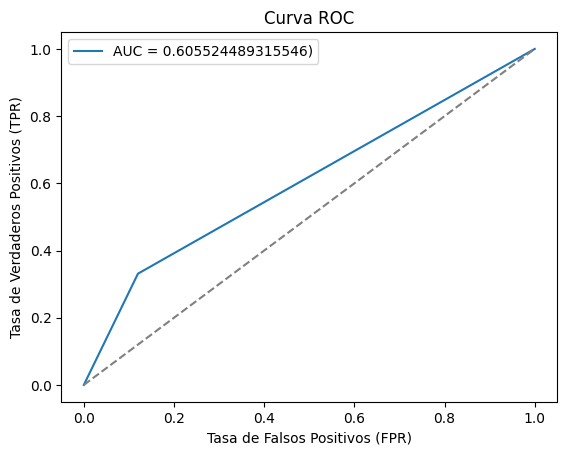

-------------------- CatBoost --------------------
Accuracy: 0.8506711409395973
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.89      0.95      0.92      1041
        True       0.32      0.15      0.21       151

    accuracy                           0.85      1192
   macro avg       0.60      0.55      0.56      1192
weighted avg       0.81      0.85      0.83      1192

Matriz de Confusion:
[[991  50]
 [128  23]]
Curva ROC:


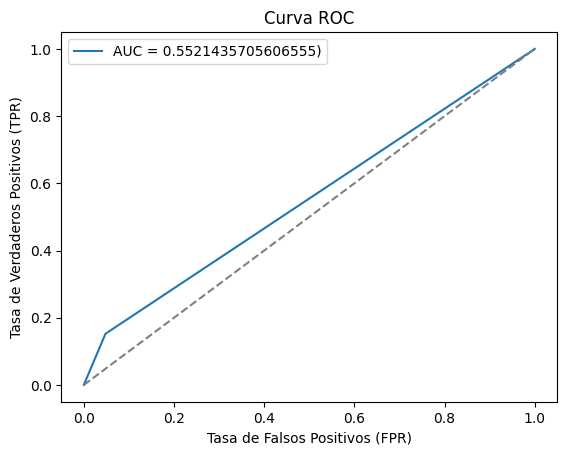

--------------------Overtaking--------------------
-------------------- XGBoost --------------------
Accuracy: 0.677013422818792
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.98      0.65      0.78      1044
        True       0.26      0.89      0.41       148

    accuracy                           0.68      1192
   macro avg       0.62      0.77      0.59      1192
weighted avg       0.89      0.68      0.73      1192

Matriz de Confusion:
[[675 369]
 [ 16 132]]
Curva ROC:


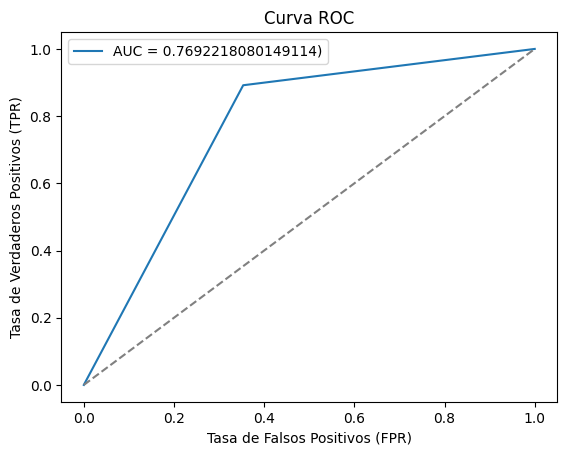

-------------------- CatBoost --------------------
Accuracy: 0.7541946308724832
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.96      0.75      0.84      1044
        True       0.31      0.78      0.44       148

    accuracy                           0.75      1192
   macro avg       0.63      0.76      0.64      1192
weighted avg       0.88      0.75      0.79      1192

Matriz de Confusion:
[[784 260]
 [ 33 115]]
Curva ROC:


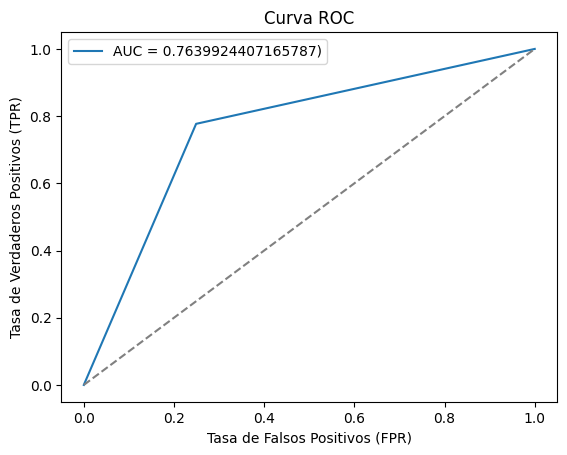

--------------------Stopping--------------------
-------------------- XGBoost --------------------
Accuracy: 0.7667785234899329
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.78      0.90      0.83       772
        True       0.74      0.52      0.61       420

    accuracy                           0.77      1192
   macro avg       0.76      0.71      0.72      1192
weighted avg       0.76      0.77      0.76      1192

Matriz de Confusion:
[[694  78]
 [200 220]]
Curva ROC:


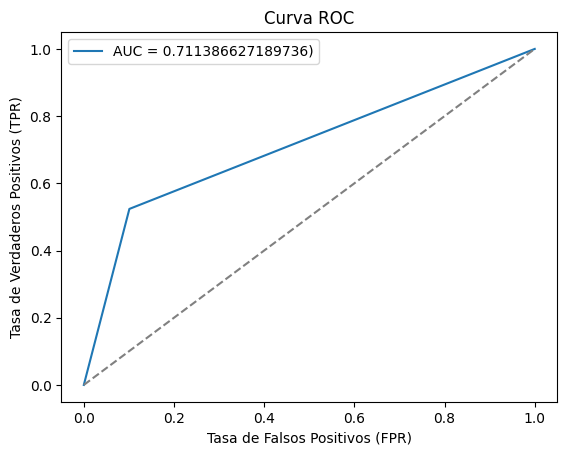

-------------------- CatBoost --------------------
Accuracy: 0.7432885906040269
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.73      0.96      0.83       772
        True       0.84      0.34      0.48       420

    accuracy                           0.74      1192
   macro avg       0.78      0.65      0.66      1192
weighted avg       0.77      0.74      0.71      1192

Matriz de Confusion:
[[744  28]
 [278 142]]
Curva ROC:


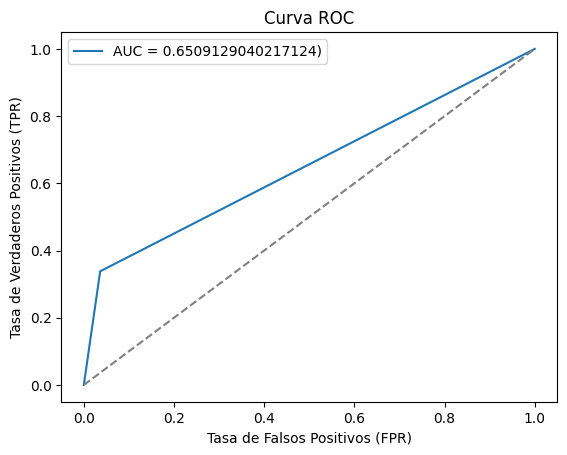

--------------------Turnings--------------------
-------------------- XGBoost --------------------
Accuracy: 0.6711409395973155
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.80      0.74      0.77       888
        True       0.38      0.47      0.42       304

    accuracy                           0.67      1192
   macro avg       0.59      0.61      0.60      1192
weighted avg       0.70      0.67      0.68      1192

Matriz de Confusion:
[[656 232]
 [160 144]]
Curva ROC:


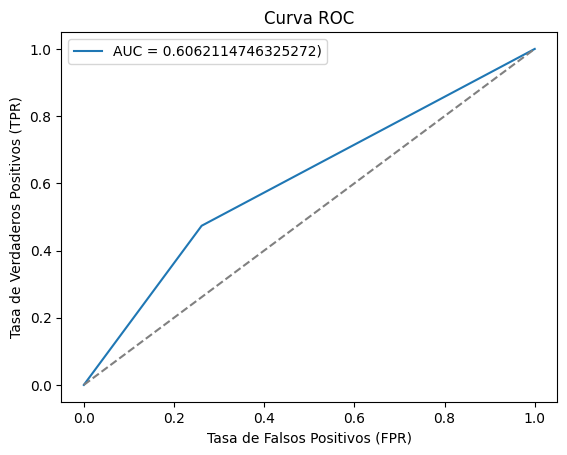

-------------------- CatBoost --------------------
Accuracy: 0.7634228187919463
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.76      0.99      0.86       888
        True       0.81      0.10      0.17       304

    accuracy                           0.76      1192
   macro avg       0.78      0.54      0.52      1192
weighted avg       0.77      0.76      0.69      1192

Matriz de Confusion:
[[881   7]
 [275  29]]
Curva ROC:


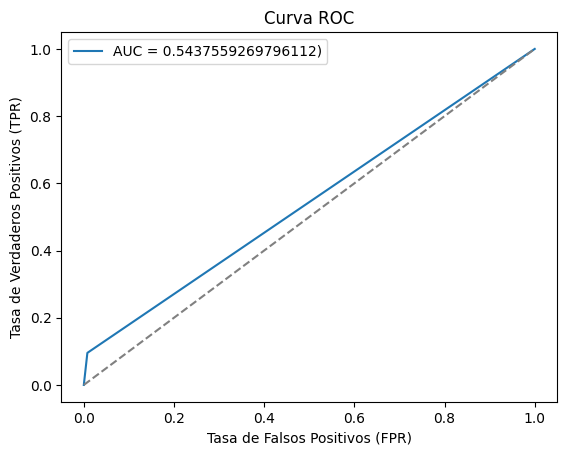

--------------------U-Turnings--------------------
-------------------- XGBoost --------------------
Accuracy: 0.8313758389261745
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.86      0.95      0.91      1023
        True       0.25      0.09      0.14       169

    accuracy                           0.83      1192
   macro avg       0.56      0.52      0.52      1192
weighted avg       0.78      0.83      0.80      1192

Matriz de Confusion:
[[975  48]
 [153  16]]
Curva ROC:


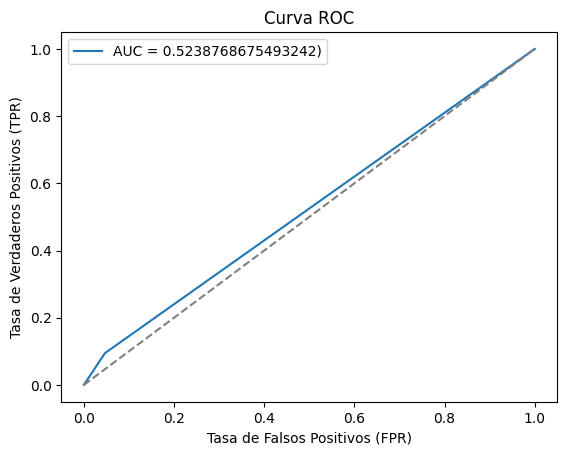

-------------------- CatBoost --------------------
Accuracy: 0.8447986577181208
Reporte de Clasificacion:
              precision    recall  f1-score   support

       False       0.87      0.97      0.91      1023
        True       0.33      0.09      0.15       169

    accuracy                           0.84      1192
   macro avg       0.60      0.53      0.53      1192
weighted avg       0.79      0.84      0.81      1192

Matriz de Confusion:
[[991  32]
 [153  16]]
Curva ROC:


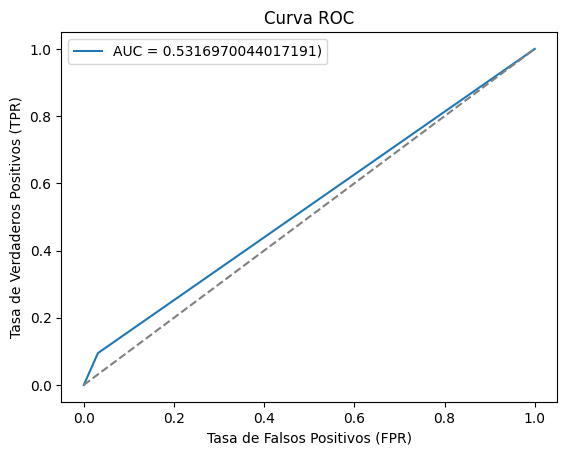

In [51]:
for idx in range(len(xgb_models)):
    print("-" * 20 + y_xgb[idx].name + "-" * 20)

    print("-" * 20, "XGBoost", "-" * 20)
    y_pred = xgb_models[idx].predict(X_test_scaled)
    get_accuracy(y_xgb[idx], y_pred)

    print("-" * 20, "CatBoost", "-" * 20)
    y_pred = cat_models[idx].predict(X_test_scaled)
    get_accuracy(y_cat[idx], y_pred)

#### Observaciones

Se observa que los modelos 1 vs All tienen un rendimiento por lo general mejor que el multiclasificador.

Por otro lado con respecto al rendimiento de los modelos XGBoost y CatBoost, se puede observar que A pesar de que CatBoost tiende a tener una mejor precisión comparado con XGBoost, XGBoost tiene un recall muchísimo más alto que CatBoost, permitiendo reconocer mejor los casos positivos (la maniobra) a pesar de incluir algunas predicciones que no lo son.

##### Explicabilidad con SHAP

SHAP (SHapley Additive exPlanations) es una técnica de explicabilidad para modelos de machine learning basada en la teoría de juegos. Permite asignar a cada característica una contribución a la predicción del modelo, mostrando de forma clara y cuantitativa cómo cada variable influye en el resultado. Esto ayuda a interpretar modelos complejos y a entender mejor sus decisiones.

Utilizamos dos funciones principales de shap para ver el impacto que tiene cada atributo en la predicción del modelo.

Al haber tangos modelos, pondremos un ejemplo del que haya tenido el mejor rendimiento, siendo el modelo XGBoost para Overtaking.

Aquí podemos ver que para le overtaking, los mayores impactos son la fuerza empleada en el gas pedal a ma5 (10 segundos) y la media de la velocidad también a 10seg seguido de RPM también. Por lo general, atributos de ventanas de larga duración (10 segundos) son los que más impactan en comparación con las de corta (1,5 segundos).

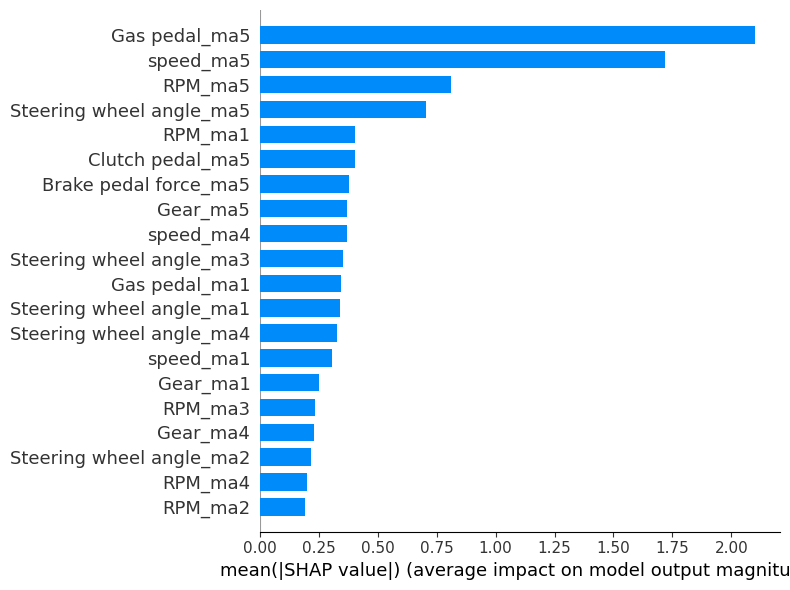

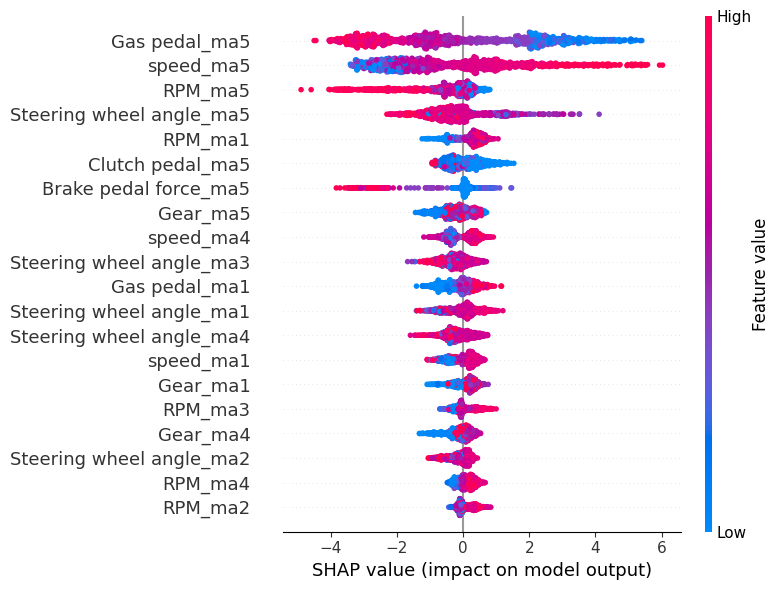

In [52]:
# Establecer figsize a (10, 10)
plt.figure(figsize=(10, 10))

explainer = shap.TreeExplainer(xgb_models[1])
shap_values = explainer.shap_values(X_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_flat.columns, index=X_test_flat.index)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", plot_size=(8,6))

shap.summary_plot(shap_values, X_test_scaled, plot_size=(8,6))

### Conclusión 

#### Ventanas

Hemos decidido aplicar ventanas solapadas principalmente para aumentar la cantidad de datos obtenidos mediante rolling windows. Sin embargo, debido a que contamos con numerosos datos recogidos por los sensores que resultan redundantes, se ha aplicado un gap de 20 unidades (1 segundo) entre cada toma para reducir la posibilidad de sesgos en el modelo por el impacto de dicha redundancia.

Se consideró aplicar ventanas no solapadas, pero podrían no tener suficientes datos para contribuir de forma efectiva al entrenamiento y generar cortes muy abruptos en la secuencia, lo cual podría ocasionar la pérdida de información importante.

Por otro lado, se observa que, aunque los moving averages de larga duración tienen un mayor impacto en la predicción del modelo en comparación con los de más corta duración o más recientes, estos últimos también aportan información valiosa. Por lo tanto, la combinación de ambas ofrece al modelo una visión más global con un contexto reciente de lo que ha ocurrido.

##### Fuga de Datos

Se sospecha fuertemente que hay una fuga de datos por parte de los atributos de latitud y longitud, principalmente del latitud.

Mediante SHAP se ve que laitutd tiene un impacto abrumador en la salida de la predicción.

Se sospecha que esto es algo específico del simulador, en la cual los recorridos parten de la misma posición o que siguen un trayecto espacial muy similar.

Debido a esto, si se mantienen estos datos de localización, el modelo tendría un rendimiento extremadamente alto para situaciones de la simulación mientras que este rendimiento no se trasladaría a uno en la vida real.

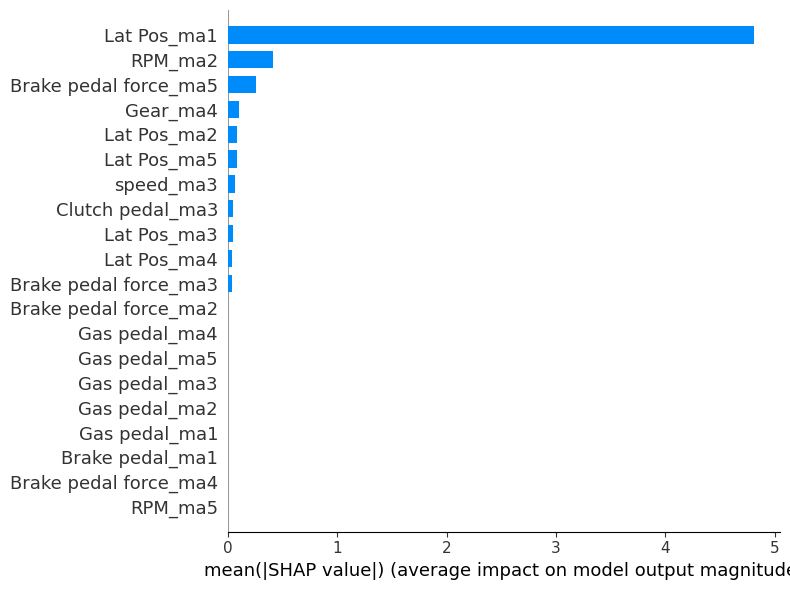
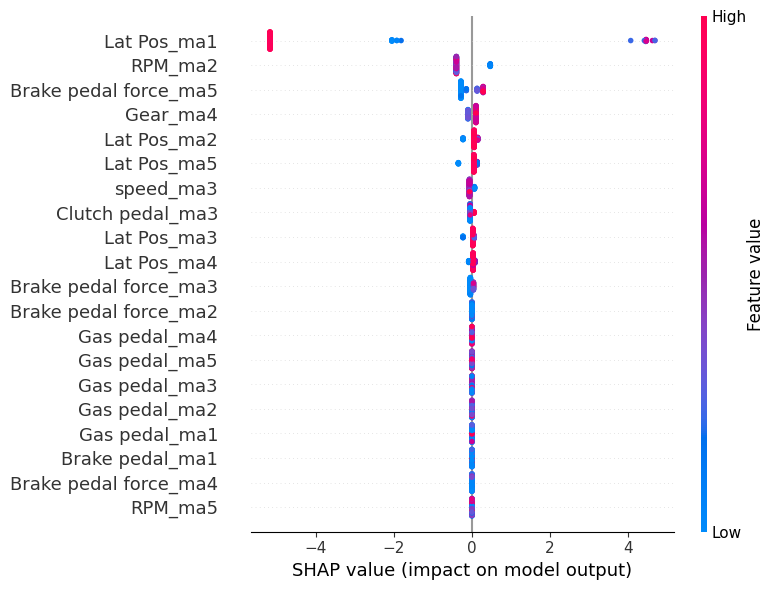
